# TPM034A Machine Learning for socio-technical systems 
## `Lab session 05: Explainable AI of a classification model for appliance usage prediction`

**Delft University of Technology**<br>
**Q2 2025**<br>
**Instructor:** Giacomo Marangoni <br>

## `Instructions`

**Lab sessions aim to:**<br>
* Show and reinforce how models and ideas presented in class are used in practice.<br>
* Help you gather hands-on machine learning skills.<br>

**Lab sessions are:**<br>
* Learning environments where you work with Jupyter notebooks and where you can get support from TAs and fellow students.<br> 
* Not graded and do not have to be submitted. 

### `Use of AI tools`
AI tools, such as ChatGPT and Co-pilot, are great tools to assist with programming. Moreover, in your later careers you will work in a world where such tools are widely available. As such, we **encourage** you to use AI tools **effectively** (both in the lab sessions and assignments). However, be careful not to overestimate the capacity of AI tools! AI tools cannot replace you: you still have to conceptualise the problem, dissect it and structure it, to conduct proper analysis and modelling. We recommend being especially **reticent** with using AI tools for the more conceptual and reflective oriented questions. 

### `Google Colab workspace set-up`

Uncomment the following cells code lines if you are running this notebook on Colab

In [1]:
# Import required Python packages and modules
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt


# Import selected functions and classes from Python packages
from os import getcwd
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Basic libraries
import numpy as np
import pandas as pd
import geopandas as gpd

# ML tools
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer,log_loss

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor

# Visualization libraries
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.ticker import FixedLocator
from sklearn.tree import plot_tree
from branca.element import Figure

# Other libraries
from pathlib import Path
from shapely.geometry import Point
from PIL import Image
import pickle
from sklearn.preprocessing import StandardScaler

In [2]:
#!git clone https://github.com/TPM034A/Q2_2025
#!pip install -r Q2_2025/requirements_colab.txt
#!mv "/content/Q2_2025/Lab_sessions/lab_session_05/data" /content/data

# `Application: Explainable AI of a classification model for appliance usage prediction` <br>

#### **Introduction**

In this notebook you are going to train and explain a Random Forest Classifier model to predict the probability of using a given appliance in the next 24 hours.

#### **Data**

1. `data/devices.pkl`: A pickle file with a pandas.DataFrame of Wh hourly energy consumption by appliance within a household of the REFIT dataset, over a period of about two years.
2. `data/devices.pkl`: A pickle file with a pandas.DataFrame of normalized weather variables: `dwpt` is Dew Point (related to moisture), `rhum` is relative humidity, `temp` is temperature, `wdir` is wind direction, `wspd` is wind speed.
3. `data/price.pkl`: A pickle file with a pandas.Series with electricity day-ahead prices in GBP/MWh.


**Learning objectives**. After completing the following exercises you will be able to: <br>

- prepare and explore appliance-level smart meter data for training a ML model to predict whether an appliance will be used or not at a given hour;
- use XAI tools to gain insights on usage behaviour;
- reflect on practical and ethical implications.

### Data preparation

In [3]:
# Load 'data/devices.pkl', 'data/weather.pkl' and 'data/price.pkl'.
# Weather is the same as in the lab session.
# Devices contains Wh consumed by given devices at each timestamp.
# Price contains electricity prices for each timestamp.

In [4]:
devices = pd.read_pickle('data/devices.pkl')
weather = pd.read_pickle('data/weather.pkl')
price = pd.read_pickle('data/price.pkl')


In [5]:
# Add a colum "Load" to devices as the sum of all appliances consumption
devices['load'] = devices.sum(axis=1)


In [6]:
# Merge all the datasets in one dataframe
data = devices.merge(weather, left_index=True, right_index=True)
data = data.merge(price, left_index=True, right_index=True)
data

,Toaster,Fridge-Freezer,Freezer,Tumble Dryer,Dishwasher,Washing Machine,Television,Microwave,Kettle,load,dwpt,rhum,temp,wdir,wspd,price
Time,,,,,,,,,,,,,,,,
2013-09-25 19:00:00,0.000000,28.381963,37.084881,0.0,0.0,0.000000,144.262599,0.000000,0.000000,209.729443,0.62500,0.774074,0.833333,0.114286,0.123684,53.49
2013-09-25 20:00:00,0.000000,50.966044,44.848896,0.0,0.0,0.000000,143.933786,0.000000,0.000000,239.748727,0.62500,0.733333,0.750000,0.085714,0.100000,41.51
2013-09-25 21:00:00,0.000000,31.829103,36.810491,0.0,0.0,0.000000,68.949239,0.000000,0.000000,137.588832,0.59375,0.737037,0.833333,0.057143,0.171053,40.06
2013-09-25 22:00:00,0.000000,34.850258,36.289157,0.0,0.0,0.000000,0.000000,0.000000,0.000000,71.139415,0.59375,0.737037,0.833333,0.171429,0.242105,42.06
2013-09-25 23:00:00,0.000000,50.380546,36.912969,0.0,0.0,0.000000,0.000000,0.000000,0.000000,87.293515,0.53125,0.703704,0.916667,0.142857,0.269737,37.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-02 06:00:00,0.000000,47.229249,47.075099,0.0,0.0,0.000000,0.000000,0.000000,0.000000,94.304348,0.50000,0.666667,0.916667,0.657143,0.293421,43.58
2015-06-02 07:00:00,0.000000,1.131783,35.833333,0.0,0.0,0.000000,3.798450,0.000000,142.232558,182.996124,0.53125,0.703704,0.916667,0.628571,0.340789,50.46
2015-06-02 08:00:00,44.817658,78.222649,37.470250,0.0,0.0,0.000000,143.184261,0.846449,104.460653,409.001919,0.56250,0.700000,0.833333,0.600000,0.388158,51.08


In [ ]:
pd.replace

In [14]:
# Consider zeros in temperature ("temp" column) as NAs, and interpolate the resulting missing values linearly
data['temp'].replace(np.nan, 0)


Time
2013-09-25 19:00:00    0.833333
2013-09-25 20:00:00    0.750000
2013-09-25 21:00:00    0.833333
2013-09-25 22:00:00    0.833333
2013-09-25 23:00:00    0.916667
                         ...   
2015-06-02 06:00:00    0.916667
2015-06-02 07:00:00    0.916667
2015-06-02 08:00:00    0.833333
2015-06-02 09:00:00    0.833333
2015-06-02 10:00:00    0.680556
Freq: h, Name: temp, Length: 14752, dtype: float64

### Data exploration

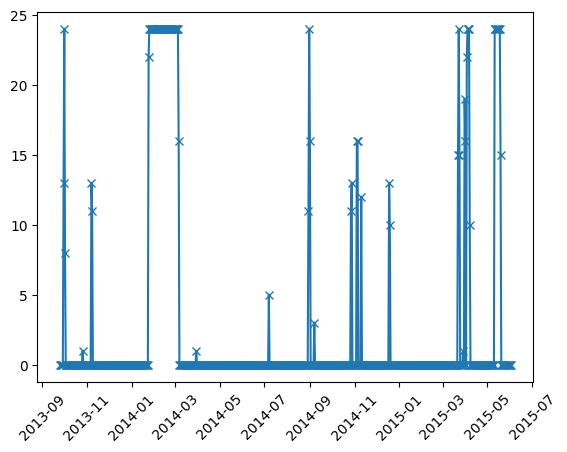

In [34]:
# Plot NAs count per day over the whole time range. Are there any evident missing periods?

# Hint: use isna(), groupby(), index.date and sum()
plt.plot(data['temp'].isna().groupby(data.index.date).sum().index, data['temp'].isna().groupby(data.index.date).sum(), marker = 'x')
plt.xticks(rotation=45)
plt.show()

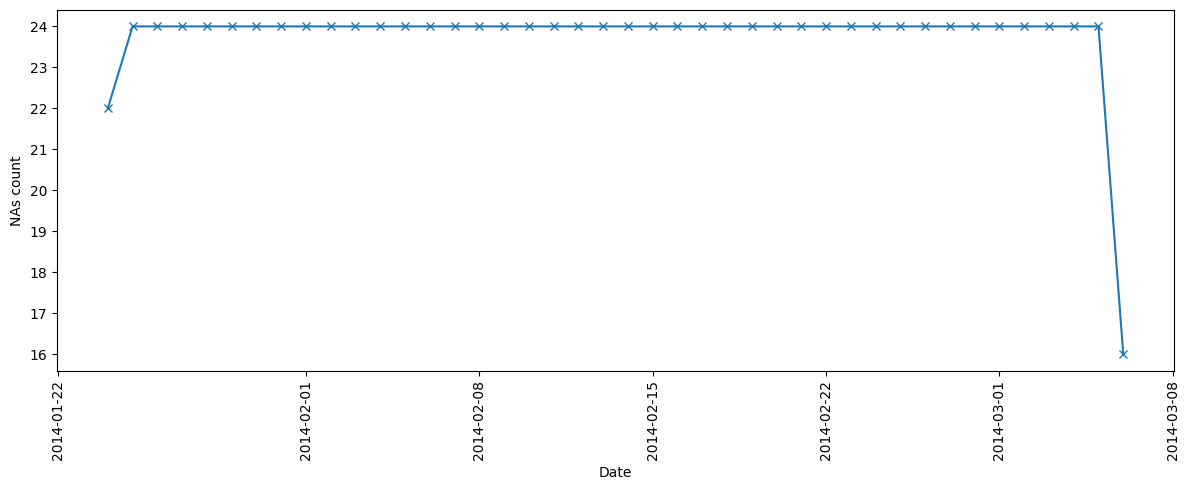

In [37]:
# 2014-01-24 to 2014-03-06 and 2015-03-31 to 2015-05-19
nas_per_day = data['temp'].isna().groupby(data.index.date).sum()

# Filter for the specific date ranges
mask = ((nas_per_day.index >= pd.to_datetime('2014-01-24').date()) & (nas_per_day.index <= pd.to_datetime('2014-03-06').date())) 
nas_filtered = nas_per_day[mask]

plt.figure(figsize=(12, 5))
plt.plot(nas_filtered.index, nas_filtered.values, marker='x')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('NAs count')
plt.tight_layout()
plt.show()

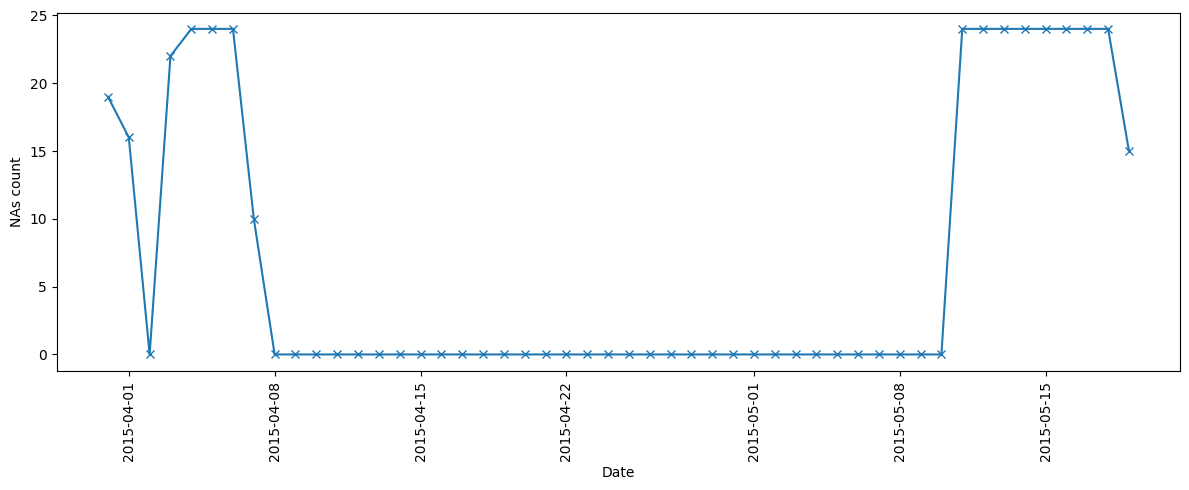

In [38]:
# 2014-01-24 to 2014-03-06 and 2015-03-31 to 2015-05-19
nas_per_day = data['temp'].isna().groupby(data.index.date).sum()

# Filter for the specific date ranges
mask = ((nas_per_day.index >= pd.to_datetime('2015-03-31').date()) & (nas_per_day.index <= pd.to_datetime('2015-05-19').date()))
nas_filtered = nas_per_day[mask]

plt.figure(figsize=(12, 5))
plt.plot(nas_filtered.index, nas_filtered.values, marker='x')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('NAs count')
plt.tight_layout()
plt.show()

In [ ]:
# In 1 year, from 2014-03-10 to 2015-03-09, which appliance cumulatively consumed the most energy?


In [46]:
mask = (data.index >= pd.to_datetime('2014-03-10')) & (data.index <= pd.to_datetime('2015-03-09'))
data.iloc[mask, 0:9].sum().idxmax() # Assuming the first 7 columns are appliances

'Tumble Dryer'

In [60]:
# Which appliance was turned on for the highest number of hours (i.e. consumption > 1Wh)?
# data[data.iloc[:, 0:9] == 0].count(axis = 0).idxmax() #.isnull()
data[data.iloc[:, 0:9] > 1].count(axis = 0).idxmax()

'Freezer'

In [ ]:
# Which appliance consumes per hour the highest?

In [65]:
data.iloc[:,0:9].mean(axis = 0).idxmax()

'Tumble Dryer'

In [ ]:
# Plot the fraction of days (y-axis) in the given year by which each appliance (color) is used for each hour (x-axis)

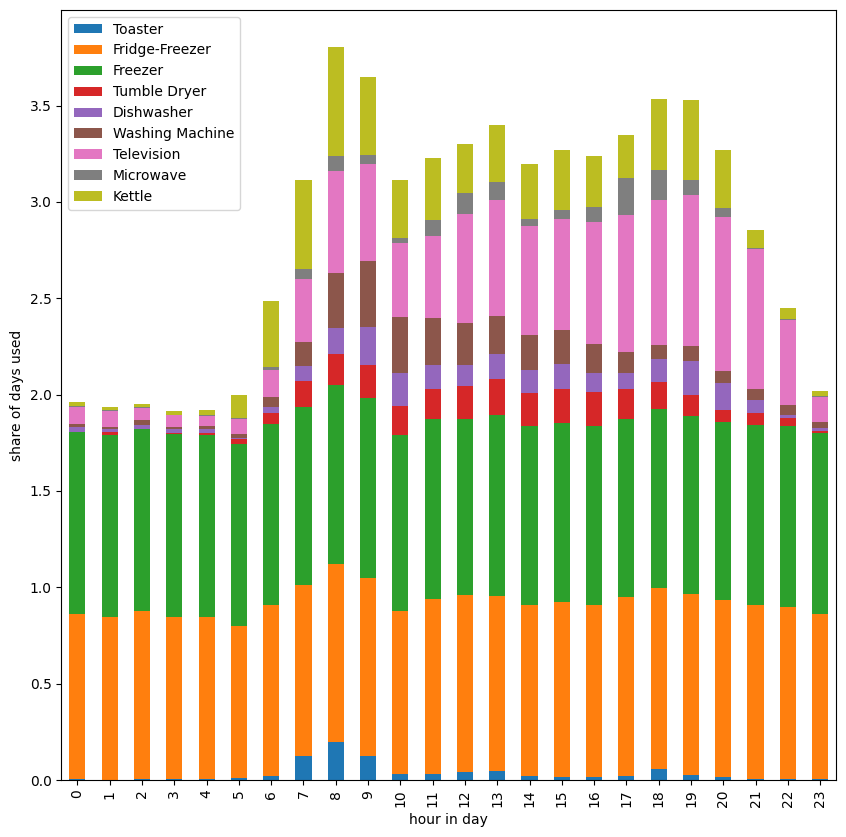

In [115]:
mask = (data.index >= pd.to_datetime('2014-03-10')) & (data.index <= pd.to_datetime('2015-03-09'))
data_year = data.iloc[mask, 0:9]
data_year_mask = (data_year > 1)
# plt.plot(data_year_mask.groupby(data_year_mask.index.hour).sum()/365, kind = 'bar', stacked = True)

fig, ax = plt.subplots( figsize= (10,10))
shares_used_df = data_year_mask.groupby(data_year_mask.index.hour).sum()/365
shares_used_df.plot(kind = 'bar', stacked = True, ax =ax)
plt.ylabel('share of days used')
plt.xlabel('hour in day')
plt.show()

### Model training

In [ ]:
# Prepare train and test datasets with the following characteristics:
# Train data period: from 2014-03-10 to 2015-03-09
# Test data period: 2015-03-10
# y feature: usage of television (i.e. consumption > 1)
# X features:
# - hour (int)
# - weekday (int)
# - weather variables
# - usage 24h before (1 if television was used at the same hour the day before)
# - activity 24h before (1 if any appliance was used at the same hour the day before)
# - usage yesterday (1 if television was used at least 1 hour during the whole day before)
# - price
# Drop NAs

# Hint for computing "usage yesterday": group usage by date, take the max, shift, then reindex to hourly using forward fill 

In [133]:
data

,Toaster,Fridge-Freezer,Freezer,Tumble Dryer,Dishwasher,Washing Machine,Television,Microwave,Kettle,load,...,temp,wdir,wspd,price,hour,weekday,tv_usage,tv_usage_24h_before,activity_24h_before,tv_usage_yesterday
Time,,,,,,,,,,,,,,,,,,,,,
2013-09-25 19:00:00,0.000000,28.381963,37.084881,0.0,0.0,0.000000,144.262599,0.000000,0.000000,209.729443,...,0.833333,0.114286,0.123684,53.49,19,2,0,0,0,NaN
2013-09-25 20:00:00,0.000000,50.966044,44.848896,0.0,0.0,0.000000,143.933786,0.000000,0.000000,239.748727,...,0.750000,0.085714,0.100000,41.51,20,2,0,0,0,NaN
2013-09-25 21:00:00,0.000000,31.829103,36.810491,0.0,0.0,0.000000,68.949239,0.000000,0.000000,137.588832,...,0.833333,0.057143,0.171053,40.06,21,2,0,0,0,NaN
2013-09-25 22:00:00,0.000000,34.850258,36.289157,0.0,0.0,0.000000,0.000000,0.000000,0.000000,71.139415,...,0.833333,0.171429,0.242105,42.06,22,2,0,0,0,NaN
2013-09-25 23:00:00,0.000000,50.380546,36.912969,0.0,0.0,0.000000,0.000000,0.000000,0.000000,87.293515,...,0.916667,0.142857,0.269737,37.91,23,2,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-02 06:00:00,0.000000,47.229249,47.075099,0.0,0.0,0.000000,0.000000,0.000000,0.000000,94.304348,...,0.916667,0.657143,0.293421,43.58,6,1,0,0,1,True
2015-06-02 07:00:00,0.000000,1.131783,35.833333,0.0,0.0,0.000000,3.798450,0.000000,142.232558,182.996124,...,0.916667,0.628571,0.340789,50.46,7,1,0,0,1,True
2015-06-02 08:00:00,44.817658,78.222649,37.470250,0.0,0.0,0.000000,143.184261,0.846449,104.460653,409.001919,...,0.833333,0.600000,0.388158,51.08,8,1,1,0,1,True


In [133]:
# Prepare features
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday

# Television column (consumption > 1Wh) - first appliance column
data['tv_usage'] = (data.iloc[:, 0] > 1).astype(int)

# Usage 24h before
data['tv_usage_24h_before'] = data['tv_usage'].shift(24).fillna(0).astype(int)

# Activity 24h before (any appliance used)
data['activity_24h_before'] = ((data.iloc[:, 0:9] > 1).any(axis=1)).shift(24).fillna(0).astype(int)

# Usage yesterday (used at least 1 hour during the whole day before)
usage_by_day = (data.iloc[:, 0] > 1).groupby(data.index.date).max()
usage_yesterday = usage_by_day.shift(1).reindex(data.index.date, fill_value=0).values
data['tv_usage_yesterday'] = usage_yesterday

# Select X features
X_features = ['hour', 'weekday', 'dwpt', 'rhum', 'temp', 'wdir', 'wspd', 
              'tv_usage_24h_before', 'activity_24h_before', 'tv_usage_yesterday', 'price']
y_feature = 'tv_usage'

# Split into train and test
mask_train = (data.index >= pd.to_datetime('2014-03-10')) & (data.index <= pd.to_datetime('2015-03-09'))
mask_test = (data.index >= pd.to_datetime('2015-03-10')) & (data.index < pd.to_datetime('2015-03-11'))

X_train = data.loc[mask_train, X_features].dropna()
y_train = data.loc[mask_train, y_feature].dropna()

X_test = data.loc[mask_test, X_features].dropna()
y_test = data.loc[mask_test, y_feature].dropna()

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: (8586, 11) samples
Test set: (24, 11) samples


In [132]:
data

,Toaster,Fridge-Freezer,Freezer,Tumble Dryer,Dishwasher,Washing Machine,Television,Microwave,Kettle,load,...,temp,wdir,wspd,price,hour,weekday,tv_usage,tv_usage_24h_before,activity_24h_before,tv_usage_yesterday
Time,,,,,,,,,,,,,,,,,,,,,
2013-09-25 19:00:00,0.000000,28.381963,37.084881,0.0,0.0,0.000000,144.262599,0.000000,0.000000,209.729443,...,0.833333,0.114286,0.123684,53.49,19,2,0,0,0,NaN
2013-09-25 20:00:00,0.000000,50.966044,44.848896,0.0,0.0,0.000000,143.933786,0.000000,0.000000,239.748727,...,0.750000,0.085714,0.100000,41.51,20,2,0,0,0,NaN
2013-09-25 21:00:00,0.000000,31.829103,36.810491,0.0,0.0,0.000000,68.949239,0.000000,0.000000,137.588832,...,0.833333,0.057143,0.171053,40.06,21,2,0,0,0,NaN
2013-09-25 22:00:00,0.000000,34.850258,36.289157,0.0,0.0,0.000000,0.000000,0.000000,0.000000,71.139415,...,0.833333,0.171429,0.242105,42.06,22,2,0,0,0,NaN
2013-09-25 23:00:00,0.000000,50.380546,36.912969,0.0,0.0,0.000000,0.000000,0.000000,0.000000,87.293515,...,0.916667,0.142857,0.269737,37.91,23,2,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-02 06:00:00,0.000000,47.229249,47.075099,0.0,0.0,0.000000,0.000000,0.000000,0.000000,94.304348,...,0.916667,0.657143,0.293421,43.58,6,1,0,0,1,True
2015-06-02 07:00:00,0.000000,1.131783,35.833333,0.0,0.0,0.000000,3.798450,0.000000,142.232558,182.996124,...,0.916667,0.628571,0.340789,50.46,7,1,0,0,1,True
2015-06-02 08:00:00,44.817658,78.222649,37.470250,0.0,0.0,0.000000,143.184261,0.846449,104.460653,409.001919,...,0.833333,0.600000,0.388158,51.08,8,1,1,0,1,True


In [130]:
data['hour']= data.index.hour
data['weekday']= data.index.weekday
columns_x = ['hour', ]
X = data
data.head()

SyntaxError: cannot assign to subscript here. Maybe you meant '==' instead of '='? (2611590961.py, line 1)

In [ ]:
# Train a Random Forest Classifier according to the directions given above.

In [ ]:
# Plot the test vs the predicted Usage

### Model explanation

In [ ]:
# Use LIME to understand the prediction for 2015-03-10 (test day) at 20:00. What can you conclude?

In [ ]:
# Compute the SHAP values for the 24 hours of the test dataset with a KernelExplainer.
# Use a 100 sample of the train dataset as background dataset.
# Slice the SHAP matrix returned by calling the explainer to get only values for classifying a positive prediction of television activity (class = 1).

In [ ]:
# Plot the SHAP values for each feature and test sample

In [ ]:
# What are the 3 most predictive features?

In [ ]:
# Explain the 14:00 and 20:00 prediction of the test day. How could you interpret the difference? Comment also on the comparison with what found with LIME.

In [ ]:
# In what hours is the expected probability of watching television highest, across the train dataset? 
# Hint: use a partial dependence plot

In [ ]:
# Compare the partial dependence plot of expected probability of watching television (y-axis) by hour (x-axis) with
# a scatter plot of SHAP values (y-axis) for the 24 hours test samples, by hour (x-axis).
# Comment on their similarity/difference.

# Hint: use shap.plots.scatter for the latter

In [ ]:
# What is the expected probability of watching television given the electricity price throughout the train dataset?
# How could one interpret this relationship?

### Reflections

In [ ]:
# What strategies could you use to improve the accuracy of predicting TV usage? What are the implications for interpretability?

In [ ]:
# What could be the benefits to a user of a XAI-informed model for predicting appliances usage? What could be the risks?